In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Link to the data:
https://drive.google.com/file/d/1ITE-wx5pIenrk-c0v0ovUyu6-V1OOv26/view?usp=sharing

*(this is a subset of "skin-cancer-mnist-ham10000")*

In [2]:
df = pd.read_csv('data/HAM2000/metadata.csv')
full_name = {
    'bcc': 'Basal cell carcinoma',
    'bkl': 'Benign keratosis-like lesions',
    'mel': 'Melanoma',
    'nv': 'Melanocytic nevi'
}
df['dx_full'] = df['dx'].map(full_name.get)
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dx_full
0,HAM_0006518,ISIC_0027618,nv,follow_up,35.0,male,back,Melanocytic nevi
1,HAM_0004666,ISIC_0029165,nv,follow_up,55.0,male,upper extremity,Melanocytic nevi
2,HAM_0006455,ISIC_0029690,nv,follow_up,50.0,male,lower extremity,Melanocytic nevi
3,HAM_0003653,ISIC_0030139,nv,histo,45.0,male,back,Melanocytic nevi
4,HAM_0001330,ISIC_0026818,nv,histo,20.0,female,abdomen,Melanocytic nevi


In [3]:
transfo = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])
dataset = torchvision.datasets.ImageFolder(root='data/HAM2000/', transform=transfo)
dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True, num_workers=1)
class_names = [full_name[name] for name in dataset.find_classes('data/HAM2000/')[0]]

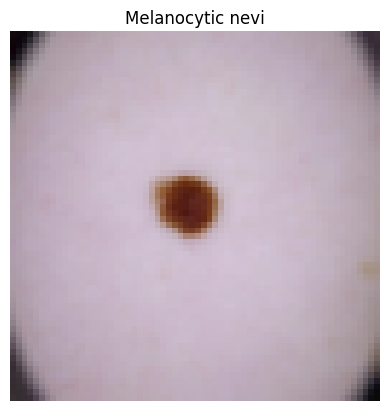

In [4]:
for image, label in dataset_loader:
    plt.imshow(image[0].permute(1, 2, 0))
    plt.title(class_names[label[0]])
    plt.axis('off')
    plt.show()
    break

In [5]:
class SkinNet(nn.Module):
    def __init__(self, hidden_size1=512, hidden_size2=32):
        super(SkinNet, self).__init__()
        self.fc0 = nn.Linear(3*64*64, hidden_size1)
        self.fc1 = nn.Linear(hidden_size1, hidden_size2)
        self.fc2 = nn.Linear(hidden_size2, 4)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = x.view(-1, 3*64*64)
        x = self.relu(self.fc0(x))
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

In [6]:
model = SkinNet()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.0001)

criterion = nn.MSELoss()

num_epochs = 10
losses = []

In [7]:
# train the model
for epoch in range(1, num_epochs+1):
    running_loss = 0.0
    for image, label in dataset_loader:
        image = image.to(device)
        label = label.to(device)
        # one hot encoding of the labels
        label = torch.nn.functional.one_hot(label, num_classes=4).float()
        output = model(image)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    running_loss /= len(dataset_loader)
    losses.append(running_loss)
    print(f'Epoch [{epoch}/{num_epochs}], Loss: {running_loss:.7f}')

Epoch [1/10], Loss: 0.189531
Epoch [2/10], Loss: 0.189337
Epoch [3/10], Loss: 0.189357
Epoch [4/10], Loss: 0.189106
Epoch [5/10], Loss: 0.189155
Epoch [6/10], Loss: 0.189220
Epoch [7/10], Loss: 0.189181
Epoch [8/10], Loss: 0.188977
Epoch [9/10], Loss: 0.188981
Epoch [10/10], Loss: 0.188957


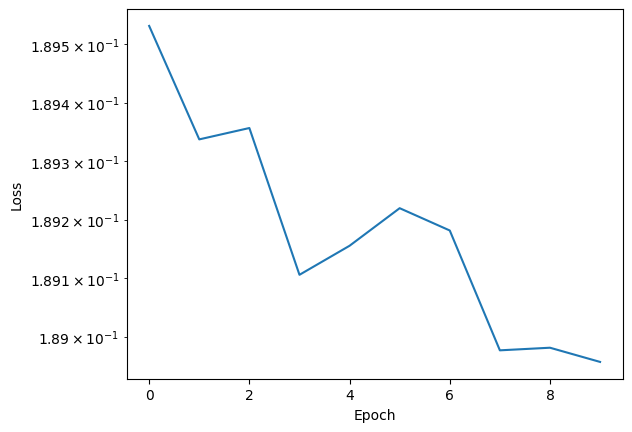

In [8]:
plt.semilogy(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()